In [11]:
#import sys
#!{sys.executable} -m pip install esim
#%pip install esim

In [12]:
import numpy as np
#from esim.utils.plotting import DFT
#from esim.utils import plotting 
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
np.random.seed(42)

## Constants \& Circuit Setup Functions

In [13]:
w0 = omega_z = 2*np.pi*30e6
kB = 1.380649e-23
dt = 1e-13
R = resistance = 5000e3
temp_res = 0.4
q  = -1.602177e-19
deff = 1e-3
noise_fact = -q/deff

Q = 3000
bandwidth = 1./dt
noise_ampl = np.sqrt(4.*kB*temp_res*resistance*bandwidth)

R = resistance
C = 1/(w0*R*Q)
L = Q*R/w0
delta_f = w0/Q
print(f'R: {R:.2e} Ohm, L: {L*1e6:.2f} uH, C: {C*1e9:.2e} nF')
print(f'w0: {w0:.2e}, w0: {1/np.sqrt(L*C):.2e}, Q: {1/R*np.sqrt(L/C)}, Bandwidth: {delta_f:.2e}')

R: 5.00e+06 Ohm, L: 79577471.55 uH, C: 3.54e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 3000.0, Bandwidth: 6.28e+04


In [14]:
w0 = omega_z = 2*np.pi*30e6
kB = 1.380649e-23
dt = 1e-13
R = resistance = 5000e3
temp_res = 0.4
q  = -1.602177e-19
deff = 1e-3
noise_fact = -q/deff

Q = 1/3000
bandwidth = 1./dt
noise_ampl = np.sqrt(4.*kB*temp_res*resistance*bandwidth)

R = resistance
C = Q/w0/R
L = R/w0/Q
delta_f = w0/Q
print(f'R: {R:.2e} Ohm, L: {L*1e6:.2f} uH, C: {C*1e9:.2e} nF')
print(f'w0: {w0:.2e}, w0: {1/np.sqrt(L*C):.2e}, Q: {R*np.sqrt(C/L)}, Bandwidth: {delta_f:.2e}')

R: 5.00e+06 Ohm, L: 79577471.55 uH, C: 3.54e-10 nF
w0: 1.88e+08, w0: 1.88e+08, Q: 0.0003333333333333333, Bandwidth: 5.65e+11


In [15]:
def parallel(a, b):
    return 1/(1/a + 1/b)

def RLC(w, R, L, C):
    s = 1j*w
    #print(s)
    return parallel((s*L + R), 1/(s*C))
    #return parallel(s*L, 1/(s*C)+R)

In [16]:
ReZ(0.1) # with DC voltage Re(Z) = R

5000000.0

## Generating Noise from Frequency Space

### Setup $Re(Z)$ and $A(\omega)$

In [17]:
def ReZ(w):
    return RLC(w, R, L, C).real

def A(w, DC=False):
    if DC:
        w = 0.1
    return np.sqrt(4*kB*temp_res*ReZ(w))

### Sanity Check on $Re(Z)$ and $A(\omega)$

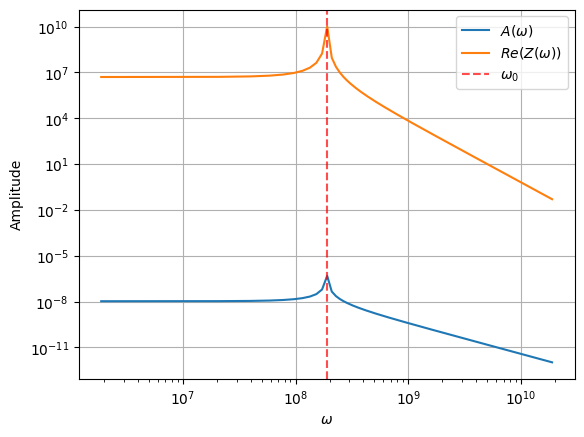

In [18]:
w = np.linspace(w0/100, w0*100, 1000)

#plt.plot(w, A(w)*1e7)
#plt.plot(w, ReZ(w)*1e-9, '--')
plt.plot(w, A(w), label=r'$A(\omega)$')
plt.plot(w, ReZ(w), label=r'$Re(Z(\omega))$')
plt.axvline(w0, label=r'$\omega_0$', color='r', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\omega$')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.show()

### Setup Noise

In [19]:
def band_limited_noise(center_freqs,bandwidth, samples=1.e6, samplerate=1.e6, DC=False): #samples=10.e4, samplerate=200100):
    """
    Generating band-limited white noise in time domain following the equation
        Noise(t) = sum_w{ A(w) * sin(2*pi*w*t + phase) }
    where the phase is generated randomly and w determined by center frequency
    and bandwidth. Frequencies beyond the range will be cutoff.
    
    Params:
        center_freqs: float
            Center frequency for noise frequency spectrum. A single float number
            in our case for now.
        bandwidth: float
            Bandwidth of the noise. This is somthing I still need to explore, 
            current trials include: w0, w0*10, w0*100, 1/dt.
        samples: int or float
            Number of samples needed in time domain, or number of time steps 
            wanted. This method assumes a non-Markovian noise so the unit of
            time step does not matter as much in this case.
        samplerate: int or float
            Number of samples collected within the time period defined by SAMPLES.
            This should be 1/dt, but note that 1/dt gives a large number.
        DC: bool
            If true, then A(w) = 1 for all w. Default to False.
         
    Returns:
        * Frequencies used to generate the noise
        * FFT frequencies
        * Amplitude of noise in frequency domain
        * Time steps
        * Amplitude of noise in time domain
    """     
    
    ## Generate time steps
    t = np.linspace(0, samples/samplerate, int(samples))
    
    ## Generate frequencies and phases
    min_freq, max_freq = center_freqs-bandwidth/2., center_freqs+bandwidth/2.
    #freqs = np.arange(min_freq, max_freq+1, samples/samplerate) # This is memory-consuming if samplerate is large
    #phases = np.random.rand(len(freqs))*2*np.pi
    #generator = iter(zip(freqs,phases))
    freqs = [] # Empty holder bc recording all freqs is too memory-consuming
    step_size = samples/samplerate
    
    ## Generate signal
    signal=np.zeros(len(t))
    progress_bar = tqdm(total=max_freq-min_freq, position=0, leave=True)
    
    freq = min_freq
    while freq <= max_freq:
        phase = np.random.rand() * 2 * np.pi
        #freq, phase = next(generator)
        signal += A(freq, DC=DC) * np.sin(2 * np.pi * freq * t + phase)
        freq += step_size
        progress_bar.update(step_size)
        
    progress_bar.close()
    
    ## Return the results
    x=signal
    X = np.fft.fft(x)
    N = len(X)
    
    return freqs, np.fft.fftfreq(N)*samplerate, X, t, signal

In [20]:
def band_limited_noise_sampled(center_freqs,bandwidth, samples=1.e6, samplerate=1.e6, DC=False, n_freq=1e6): #samples=10.e4, samplerate=200100):
    """
    Generating band-limited white noise in time domain following the equation
        Noise(t) = sum_w{ A(w) * sin(2*pi*w*t + phase) }
    where the phase is generated randomly and w determined by center frequency
    and bandwidth. Frequencies beyond the range will be cutoff. w is sampled
    in the frequency range.
    
    Params:
        center_freqs: float
            Center frequency for noise frequency spectrum. A single float number
            in our case for now.
        bandwidth: float
            Bandwidth of the noise. This is somthing I still need to explore, 
            current trials include: w0, w0*10, w0*100, 1/dt.
        samples: int or float
            Number of samples needed in time domain, or number of time steps 
            wanted. This method assumes a non-Markovian noise so the unit of
            time step does not matter as much in this case.
        samplerate: int or float
            Number of samples collected within the time period defined by SAMPLES.
            This should be 1/dt, but note that 1/dt gives a large number.
        DC: bool
            If true, then A(w) = 1 for all w. Default to False.
        n_freq: int or float
            The number of frequencies sampled in the frequency range.
         
    Returns:
        * Frequencies used to generate the noise
        * FFT frequencies
        * Amplitude of noise in frequency domain
        * Time steps
        * Amplitude of noise in time domain
    """     
    
    ## Generate time steps
    t = np.linspace(0, samples/samplerate, int(samples))
    
    ## Generate frequencies and phases
    min_freq, max_freq = center_freqs-bandwidth/2., center_freqs+bandwidth/2.
    freqs = np.random.uniform(min_freq, max_freq, int(n_freq))
    phases = np.random.rand(len(freqs))*2*np.pi
    
    
    ## Generate signal
    phases = np.expand_dims(phases, axis=-1)
    wt = np.stack([t * wi for wi in tqdm(freqs, position=0, leave=True)], axis=0)
    #wt = np.matmul(freqs*np.identity(len(freqs)), T)
    Aw = np.expand_dims(A(freqs), axis=-1)
    signal = np.sum(Aw * np.sin(wt+phases), axis=0)

    
    ## Return the results
    x=signal
    X = np.fft.fft(x)
    N = len(X)
    
    return freqs, np.fft.fftfreq(N)*samplerate, X, t, signal

### $A=1$ case

In [21]:
freqs2, freq2, amp2, t2, amp22 = band_limited_noise(w0, delta_f*10, 1e6, 1e2, DC=1)

  0%|          | 2150000.0/5654866776461.627 [00:17<10420:15:37, 150744.38it/s]

KeyboardInterrupt: 

  0%|          | 2160000.0/5654866776461.627 [00:29<10420:15:37, 150744.38it/s]

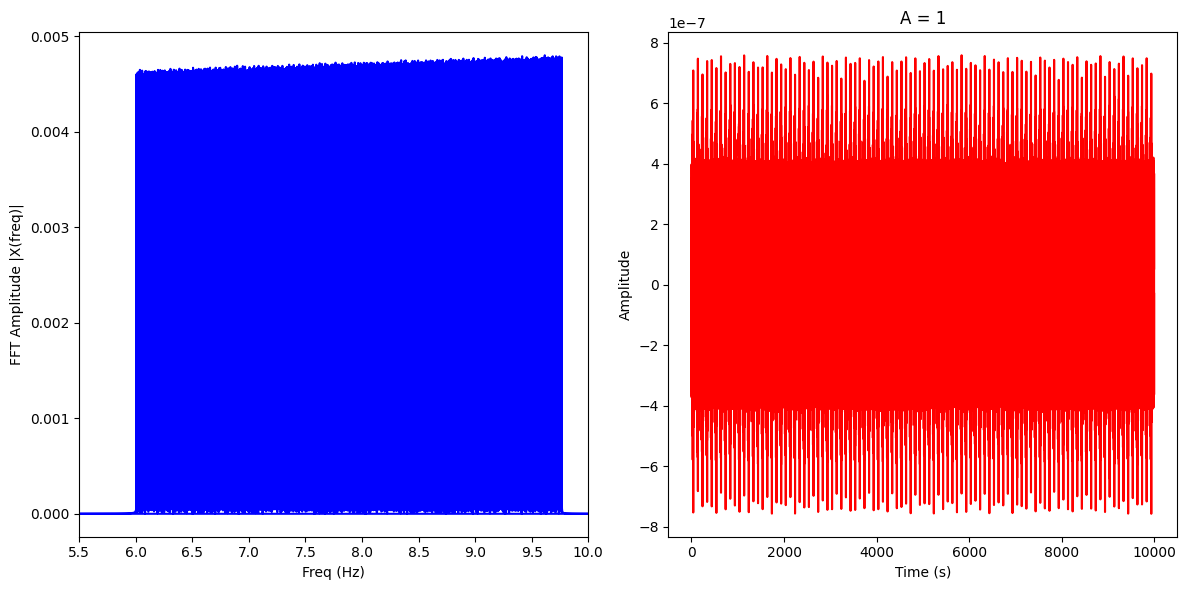

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq2, abs(amp2), 'b') #, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(5.5,10)

plt.subplot(122)
plt.plot(t2, amp22, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("A = 1")
plt.tight_layout()

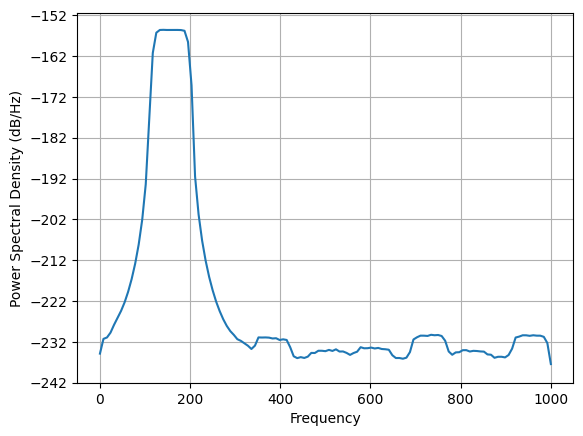

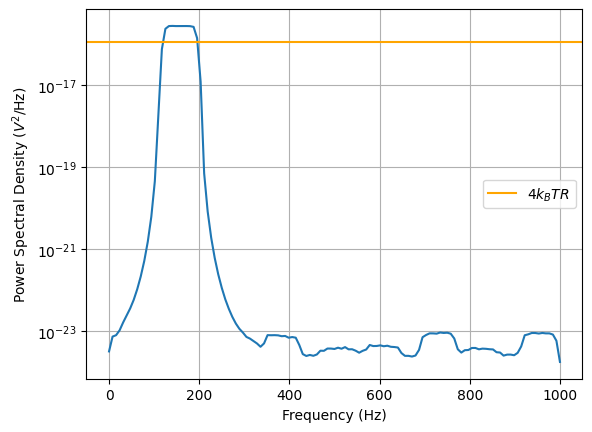

In [ ]:
P, f = plt.psd(amp22, Fs=2e3)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
plt.legend()
plt.grid()
plt.show()

### $A\equiv A(\omega)$, varied samplerate from 1e2 to 1e3 and did not see much influence

In [ ]:
freqs, freq, amp, t, amp2 = band_limited_noise(w0, delta_f*10, samples=1.e6, samplerate=1.e3)

3770000.0it [02:17, 27454.84it/s]                                       


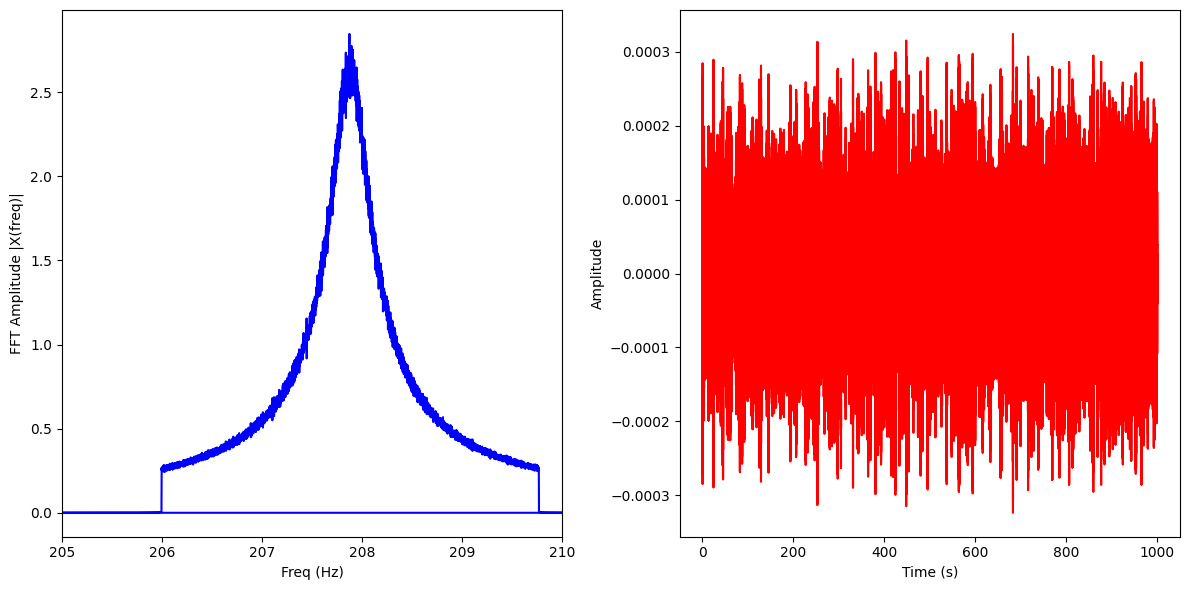

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(amp), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(205, 210)

plt.subplot(122)
plt.plot(t, amp2, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

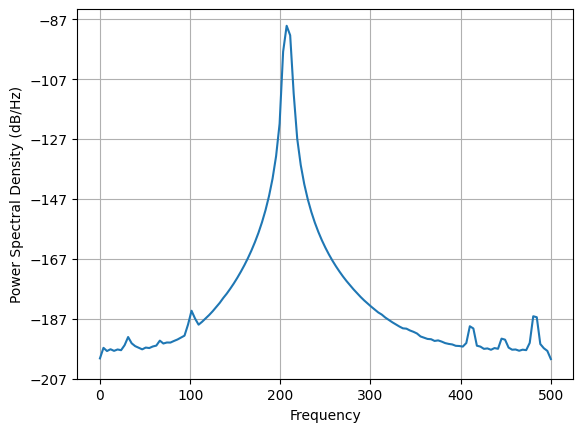

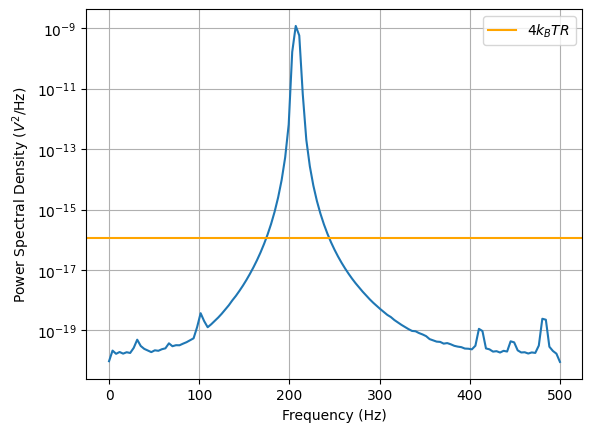

In [ ]:
P, f = plt.psd(amp2, Fs=1e3)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

### $A\equiv A(\omega)$, increased bandwidth and saw slight shape changes in PSD

In [ ]:
freqs, freq, amp, t, amp2 = band_limited_noise(w0, delta_f*100, samples=1.e6, samplerate=1e2)

37700000.0it [02:21, 265654.22it/s]                                       


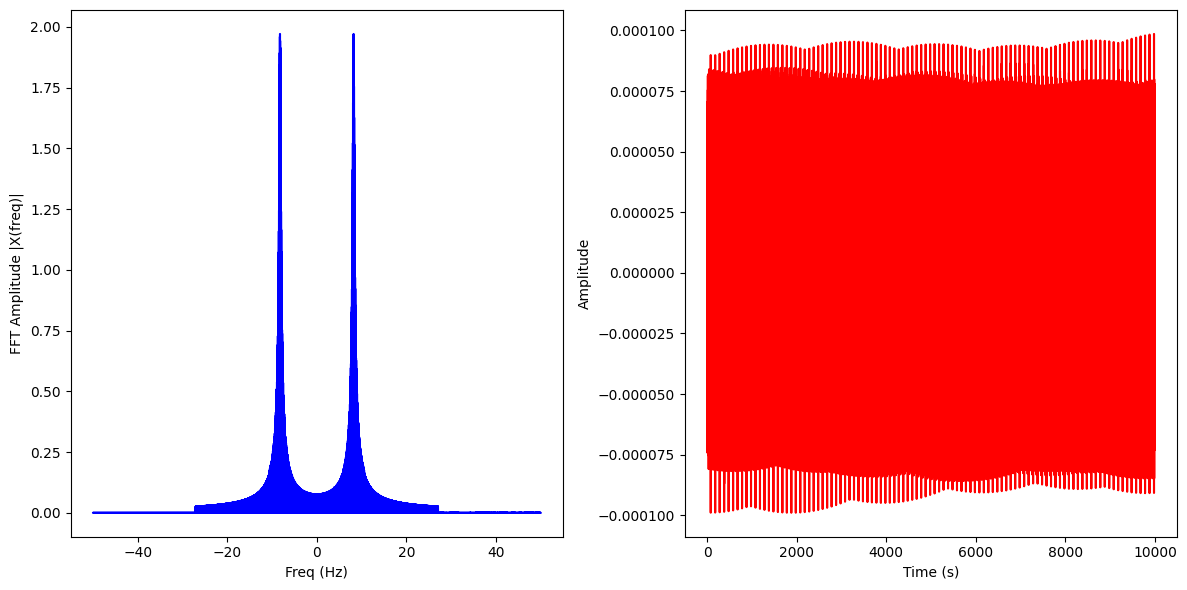

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(amp), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
##plt.xlim(0.058, 0.063)

plt.subplot(122)
plt.plot(t, amp2, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

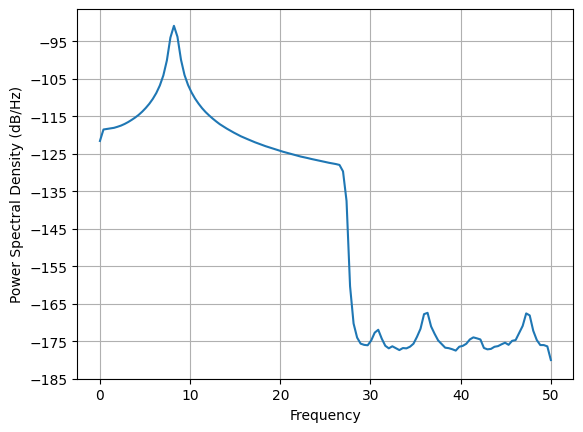

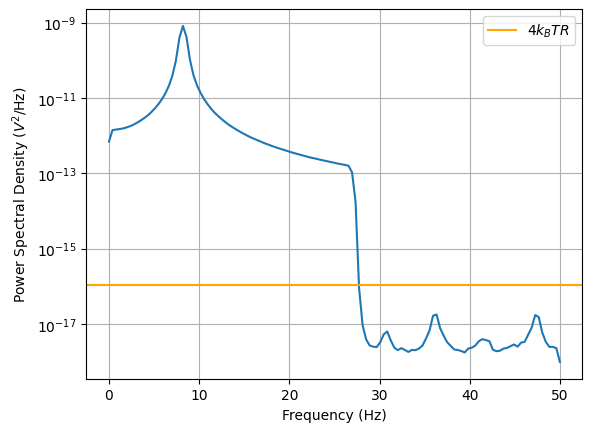

In [ ]:
P, f = plt.psd(amp2, Fs=1e2)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

### Testing bandwidth = 1/dt and samplerate = 1/dt, encountering memory outage due to large frequency ranges, solved but still takes a long time

In [ ]:
freqs3, freq3, amp3, t3, amp23 = band_limited_noise(w0, delta_f*10, samples=1.e6, samplerate=1e6)

  0%|          | 16100.0/3769911.184307754 [05:22<19:16:27, 54.10it/s]

KeyboardInterrupt: 

  0%|          | 16101.0/3769911.184307754 [05:36<19:16:27, 54.10it/s]

In [ ]:
freqs3, freq3, amp3, t3, amp23 = band_limited_noise_sampled(w0, 1e13, samples=1.e6, samplerate=1e13, n_freq=1e13)

MemoryError: Unable to allocate 72.8 TiB for an array with shape (10000000000000,) and data type float64

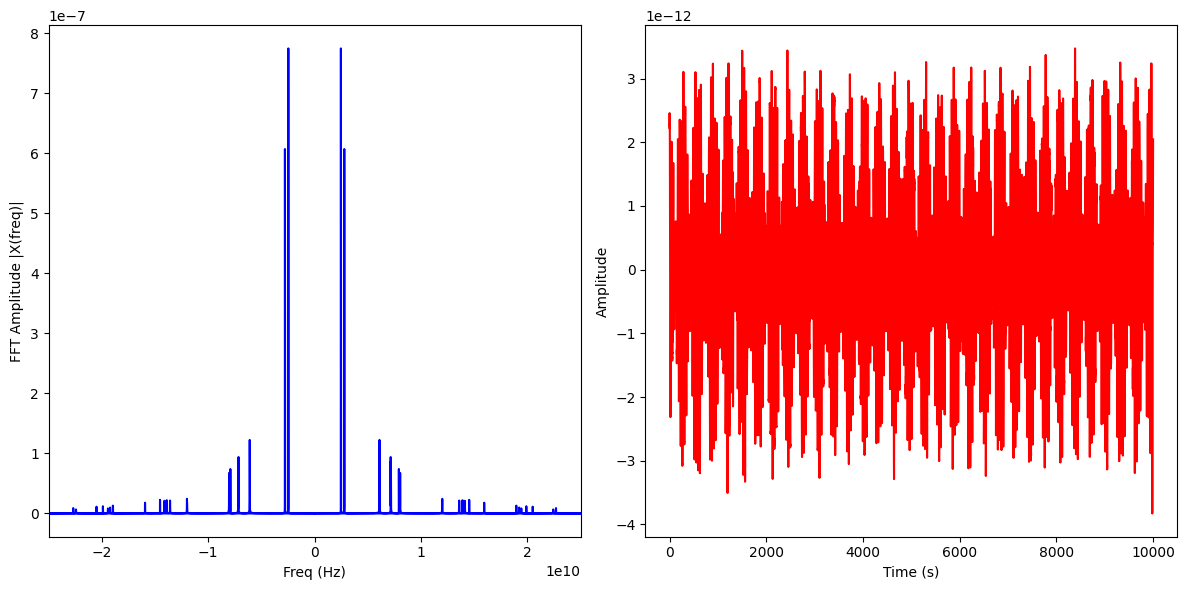

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq3, abs(amp3), 'b')#, markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-0.25e11, 0.25e11)

plt.subplot(122)
plt.plot(t, amp23, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

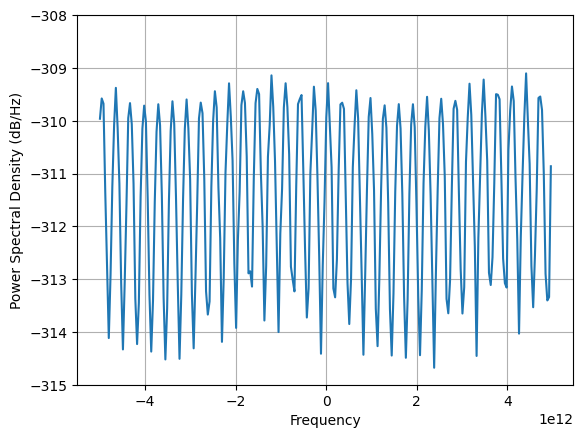

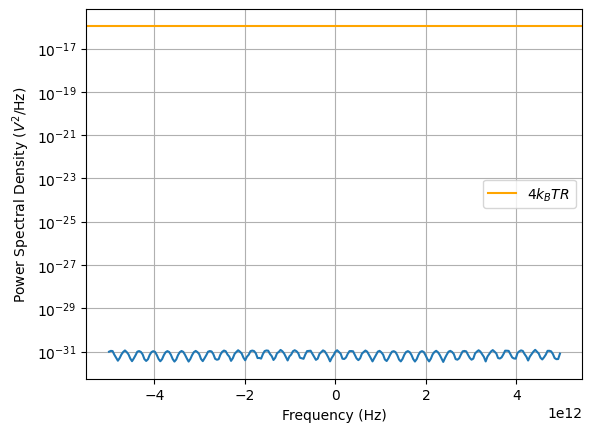

In [ ]:
P, f = plt.psd(amp3, Fs=1e13)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
#plt.plot(4*kB*temp_res*ReZ(f))
plt.legend()
plt.grid()
plt.show()

## Generating Noise from Time Domain

### Setup Circuit Transfer Function

In [ ]:
def H0(w, Q, w0):
    return 1 / ( 1 + 1j * Q * (w / w0 - w0 / w))

In [ ]:
def H(w, R, L, C):
    s = 1j * w
    Z_LC = parallel(1/(s*C), s*L)
    Z_tot = R + Z_LC
    return Z_LC / Z_tot

In [ ]:
def find_3dB(w, A):
    A0 = max(A)
    min_diff = 1e20
    w_3dB = -1
    for i in range(len(w)):
        if abs(A[i] - 0.7*A0) < min_diff:
            w_3dB, min_diff = w[i], abs(A[i] - 0.7*A0)
    return w_3dB

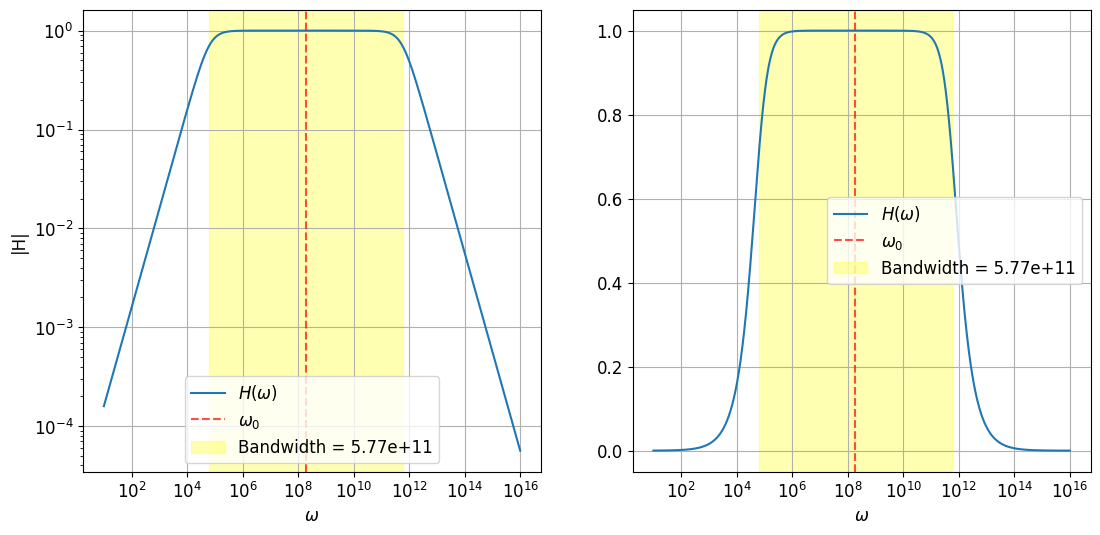

In [ ]:
w = 10**np.linspace(1, 16, 100000)

fig, ax = plt.subplots(ncols=2, figsize=(13,6))
#ax[0].plot(w, abs(H(w, 1, Q, w0)), label=r'$H(\omega)$')
ax[0].plot(w, abs(H(w, R, L, C)), label=r'$H(\omega)$')
ax[0].axvline(w0, label=r'$\omega_0$', color='r', linestyle='--', alpha=0.7)
w_L = find_3dB(w[:len(w)//2], abs(H(w, R, L, C)))
w_H = find_3dB(w[len(w)//2:], abs(H(w, R, L, C))[len(w)//2:])
ax[0].axvspan(w_L, w_H, label=f'Bandwidth = {(w_H - w_L):.2e}', color='yellow', alpha=0.3)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel('|H|')
ax[0].grid()
ax[0].legend()

#ax[1].plot(w, abs(H(w, 1, Q, w0)), label=r'$H(\omega)$')
ax[1].plot(w, abs(H(w, R, L, C)), label=r'$H(\omega)$')
ax[1].axvline(w0, label=r'$\omega_0$', color='r', linestyle='--', alpha=0.7)
ax[1].axvspan(w_L, w_H, label=f'Bandwidth = {(w_H - w_L):.2e}', color='yellow', alpha=0.3)
ax[1].set_xlabel(r'$\omega$')
ax[1].set_xscale('log')
ax[1].grid()
ax[1].legend()

plt.show()

### Noise Setup

In [ ]:
def wenhan_noise(Temperature, Rp, fres, QualityFactor, TotalTime, dt):

    # "white noise": https://www.quora.com/If-white-noise-has-a-uniform-pdf-then-how-can-it-have-a-Gaussian-distribution
    # Generate the JNNoise to be added into the simulation
    U_rms = np.sqrt(4 * kB * Temperature * Rp / dt)
    samples = TotalTime * 1.05 / dt
    # 1.5 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))

    # generate a initial noise signal(time domain)
    signal = np.random.normal(0, U_rms, size = len(t))
    X = np.fft.fft(signal)
    N = len(X)
    freqs = np.fft.fftfreq(N) * samplerate
    freqs[0] = 1e-5
    #f_U_noise = X / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs))
    f_U_noise = H(freqs, QualityFactor, fres) * X
    U_noise = np.fft.ifft(f_U_noise)
    JNNoise = U_noise
    # finally, turn to electric field <-- removed

    return X, freqs, JNNoise[:int(TotalTime/dt)], t[:int(TotalTime/dt)], signal[:int(TotalTime/dt)]

In [ ]:
def rlc_noise(Temperature, R, L, C, TotalTime, dt):

    # "white noise": https://www.quora.com/If-white-noise-has-a-uniform-pdf-then-how-can-it-have-a-Gaussian-distribution
    # Generate the JNNoise to be added into the simulation
    U_rms = np.sqrt(4 * kB * Temperature * R / dt)
    samples = TotalTime * 1.05 / dt
    # 1.5 is used to make  sure 
    samplerate = 1 / dt
    t = np.linspace(0, samples / samplerate, int(samples))

    # generate a initial noise signal(time domain)
    signal = np.random.normal(0, U_rms, size = len(t))
    X = np.fft.fft(signal)
    N = len(X)
    #freqs = np.fft.fftfreq(N) * samplerate
    freqs = np.fft.fftfreq(N, d=dt)
    freqs[0] = 1e-13
    #f_U_noise = X / ( 1 + 1j * QualityFactor * (freqs / fres - fres / freqs))
    f_U_noise = H(freqs, R, L, C) * X
    U_noise = np.fft.ifft(f_U_noise)
    JNNoise = U_noise
    # finally, turn to electric field <-- removed

    return X, f_U_noise, freqs, JNNoise[:int(TotalTime/dt)], t[:int(TotalTime/dt)], signal[:int(TotalTime/dt)]

### Generating Noise

In [ ]:
f_amp0, f_amp, freq, t_amp, t, t_amp0 = rlc_noise(temp_res, R, L, C, 10e-6, dt)

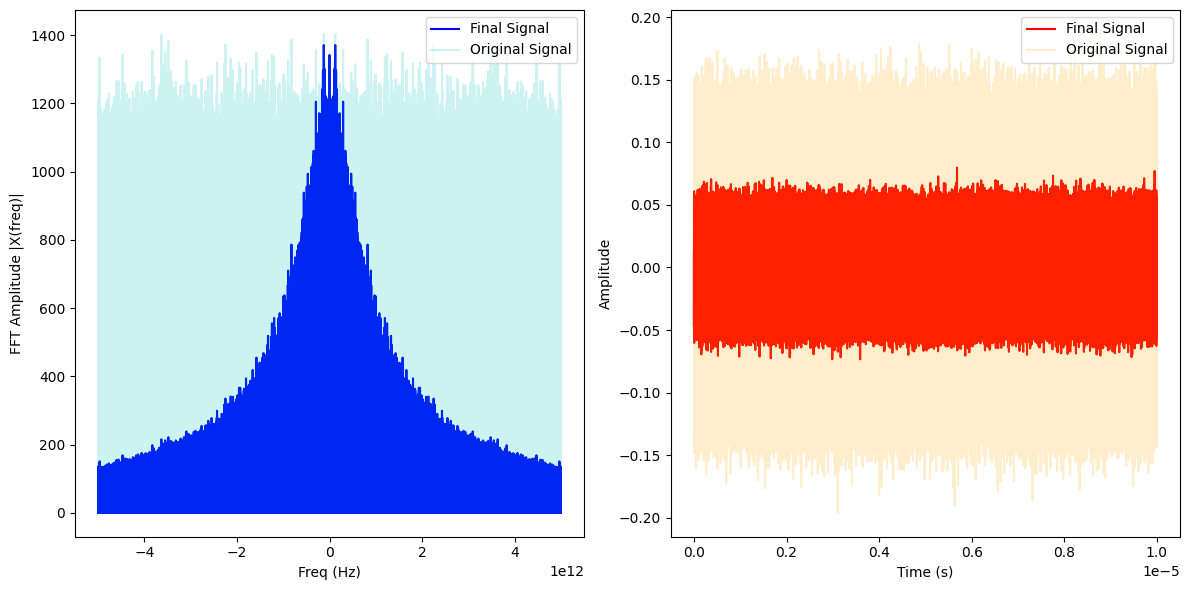

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(freq, abs(f_amp), 'b', label='Final Signal')#, markerfmt=" ", basefmt="-b")
plt.plot(freq, abs(f_amp0), color='c', alpha=0.2, label='Original Signal')
#plt.axvline(w0, label=r'$\omega_0$', color='r', linestyle='--', alpha=0.7)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.legend(loc='upper right')
#plt.xlim(5.5,10)

plt.subplot(122)
plt.plot(t, t_amp, 'r', label='Final Signal')
plt.plot(t, t_amp0, color='orange', alpha=0.2, label='Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.tight_layout()

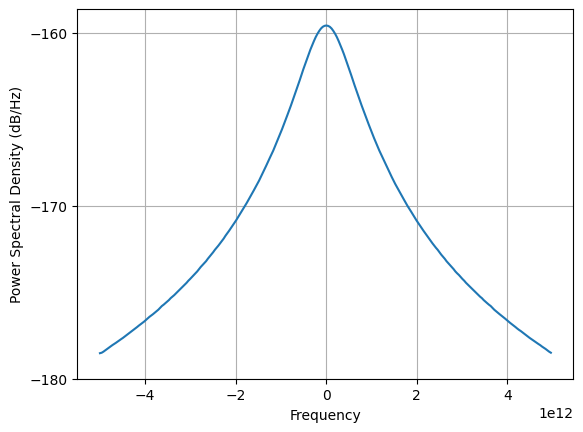

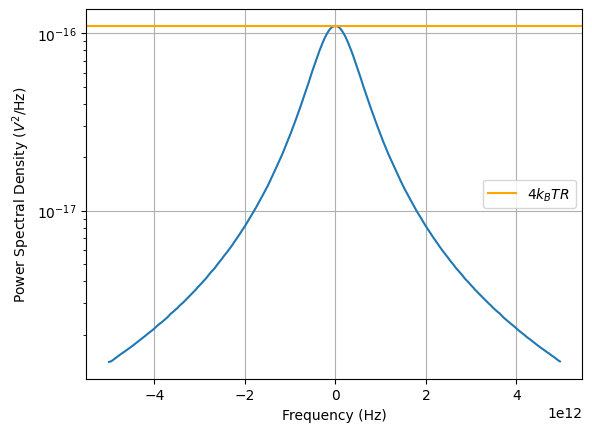

In [ ]:
P, f = plt.psd(t_amp, Fs=1/dt)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
plt.legend()
plt.grid()
plt.show()

### Comparisons

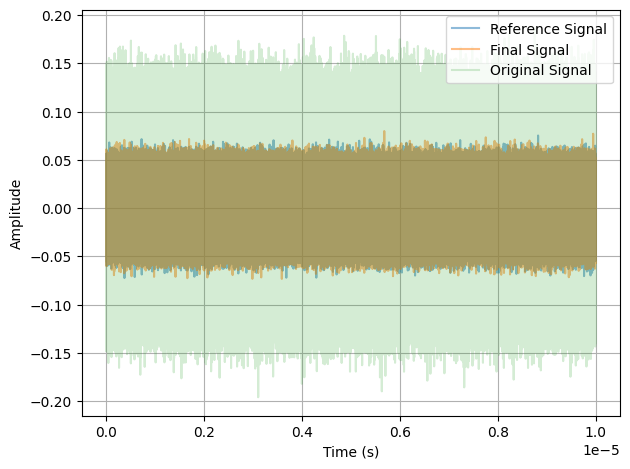

In [ ]:
t_tot = 10e-6
U_rms = np.sqrt(4 * kB * temp_res * R / dt)
signal = np.random.normal(0, 0.4*U_rms, size = int(t_tot/dt))
t = np.linspace(0, t_tot, int(t_tot/dt))

plt.plot(t, signal, alpha=0.5, label='Reference Signal')
plt.plot(t, t_amp, alpha=0.5, label='Final Signal')
plt.plot(t, t_amp0, alpha=0.2, label='Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid()
plt.tight_layout()

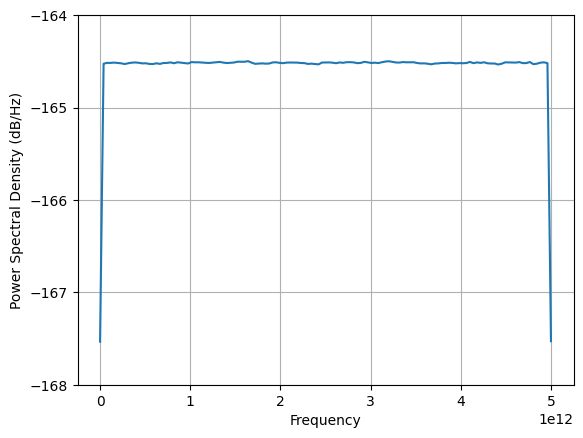

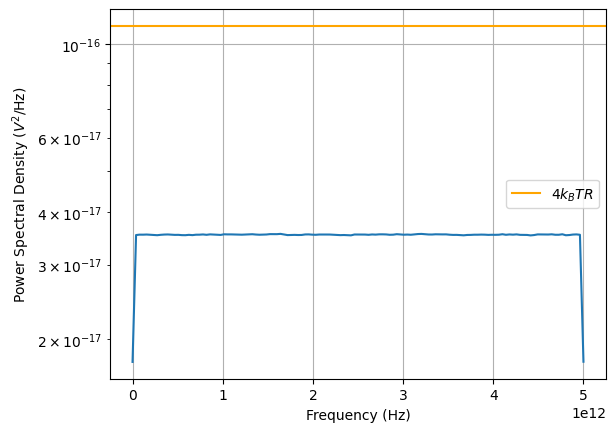

In [ ]:
P, f = plt.psd(signal, Fs=1/dt)
plt.figure()
plt.plot(f, P)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Power Spectral Density ($V^2$/Hz)')
plt.axhline(4*kB*temp_res*R, label=r'$4k_BTR$', color='orange')
plt.legend()
plt.grid()
plt.show()

## Saving the noises

In [ ]:
from esim import data_dir
import os

In [ ]:
base_dir = os.path.join(data_dir, 'noise_ver5')
base_dir

'c:\\users\\electron\\downloads\\esim\\esim\\data\\noise_ver5'

In [ ]:
for i in trange(10):
    f_amp0, f_amp, freq, t_amp, t, t_amp0 = rlc_noise(temp_res, R, L, C, 10e-6, dt)
    np.savez(os.path.join(base_dir, f'{i}.npz'), noise=t_amp)

100%|██████████| 10/10 [04:21<00:00, 26.19s/it]


### Checking Saved Noises

In [ ]:
def noise_generator(parameters):
        noise_idx = 0
        remaining_noise = 0
        base_dir = os.path.join(data_dir, 'noise_ver5')
        while True:
            if remaining_noise == 0:
                noise = np.load(os.path.join(base_dir, f'{noise_idx}.npz'))['noise']
                remaining_noise = len(noise)
                noise = iter(noise)
                noise_idx += 1
                
            yield next(noise)
            remaining_noise -= 1

In [ ]:
test_gen = noise_generator(None)

In [ ]:
test_t, test_n = [], []
for i in trange(int(30e-6/dt)):
    n = next(test_gen)
    if i % 10000 == 1:
        test_t.append(i*dt)
        test_n.append(n)

100%|██████████| 300000000/300000000 [02:17<00:00, 2183116.39it/s]


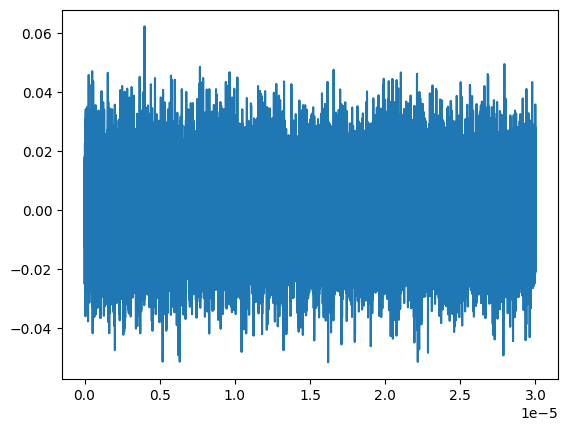

In [ ]:
plt.plot(test_t, test_n)

## Simulation Results

In [ ]:
import esim
from esim.utils import util, plotting

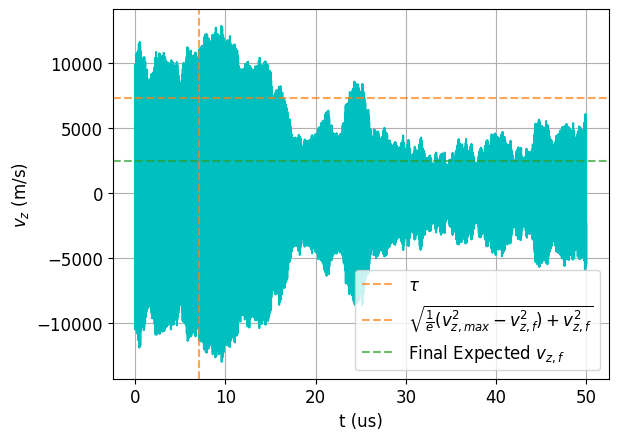

In [ ]:
config_name = f'noise_ver5'
results = np.load(f'{esim.output_dir}/{config_name}/results.npz')
param = util.get_parameters(config_name)
tau = param.m * param.deff**2 / param.q**2 / param.resistance * 1e6
vz_f = np.sqrt(param.kB*param.temp_res/param.m)
E0 = max(results['vz'][:100])**2
Ef = vz_f**2
E_tau = np.exp(-1)*(E0-Ef)+Ef
plotting.plot(results['t']*1e6, results['vz'], 'c-', xlabel='t (us)', ylabel='$v_z$ (m/s)', 
              vert_lines=[tau], vert_labels=[r'$\tau$'],
              hori_lines=[np.sqrt(E_tau), vz_f], hori_labels=[r'$\sqrt{\frac{1}{e} (v_{z,max}^2-v_{z,f}^2) + v_{z,f}^2}$', r'Final Expected $v_{z,f}$'])

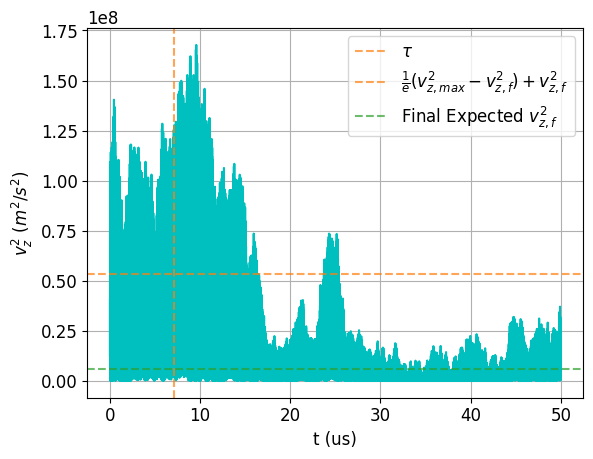

In [ ]:
config_name = f'noise_ver5'
results = np.load(f'{esim.output_dir}/{config_name}/results.npz')
param = util.get_parameters(config_name)
tau = param.m * param.deff**2 / param.q**2 / param.resistance * 1e6
vz_f_sq = param.kB*param.temp_res/param.m
E0 = max(results['vz'][:100])**2
Ef = vz_f**2
E_tau = np.exp(-1)*(E0-Ef)+Ef
plotting.plot(results['t']*1e6, results['vz']**2, 'c-', xlabel='t (us)', ylabel='$v_z^2$ ($m^2/s^2$)', 
              vert_lines=[tau], vert_labels=[r'$\tau$'],
              hori_lines=[E_tau, Ef], hori_labels=[r'$\frac{1}{e} (v_{z,max}^2-v_{z,f}^2) + v_{z,f}^2$', r'Final Expected $v_{z,f}^2$'])

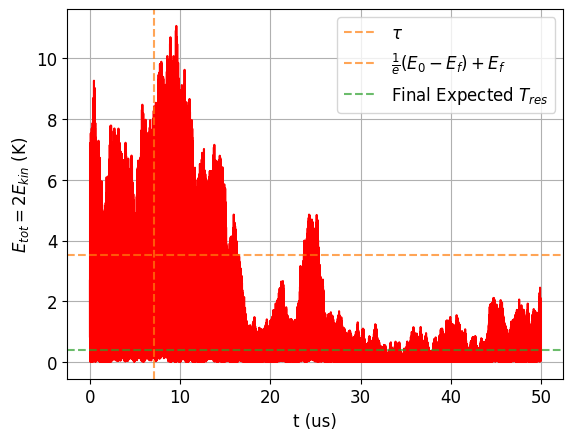

In [ ]:
config_name = f'noise_ver5'
results = np.load(f'{esim.output_dir}/{config_name}/results.npz')
param = util.get_parameters(config_name)
tau = param.m * param.deff**2 / param.q**2 / param.resistance * 1e6
#vz_f_sq = param.kB*param.temp_res/param.m

E0 = max(results['vz'][:100])**2*param.m/param.kB
Ef = temp_res
E_tau = (np.exp(-1)*(E0-Ef)+Ef)

plotting.plot(results['t']*1e6, param.m*results['vz']**2/param.kB, 'r-', xlabel='t (us)', ylabel='$E_{tot} = 2E_{kin}$ (K)', 
              vert_lines=[tau], vert_labels=[r'$\tau$'],
              hori_lines=[E_tau, temp_res], hori_labels=[r'$\frac{1}{e}(E_0 - E_f)+E_f$', r'Final Expected $T_{res}$'])